## Imports

In [1]:
import os
import sys
import time
import joblib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [5]:
# AE
lat_dim_ae = 50
inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(lat_dim_ae, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

start_time = time.time()
autoencoder.fit(x_train_flat, x_train_flat, epochs=10)
AE_train_time = time.time() - start_time

x_train_ae = autoencoder.predict(x_train_flat)
x_test_ae = autoencoder.predict(x_test_flat)
x_train_ae.shape

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0417
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0111
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0088
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0075
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0064
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0061
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0059
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0057
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0056
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(60000, 784)

In [6]:
# SVD
lat_dim_svd = 12
svd = TruncatedSVD(n_components=lat_dim_svd*lat_dim_svd)

start_time = time.time()
svd.fit(x_train_ae)
# svd.fit(x_train_flat)
svd_train_time = time.time() - start_time

x_train_svd = svd.transform(x_train_ae)
x_test_svd = svd.transform(x_test_ae)
# x_train_svd = svd.transform(x_train_flat)
# x_test_svd = svd.transform(x_test_flat)
x_train_svd.shape

(60000, 144)

In [7]:
x_train_reduced = x_train_svd
x_test_reduced = x_test_svd

In [8]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 37.24818730354309
SVD train time: 2.929168462753296


## evaluation on Decision Trees

### Decision Trees model

In [9]:
def make_mlp_model(x_train, y_train):
    model = DecisionTreeClassifier()
    model.fit(x_train, y_train)
    return model

### Other Functions

In [10]:
def print_model_size(model_to_save):
    file_path =  'my_model.joblib'
    joblib.dump(model_to_save, file_path)
    
    file_size_bytes = os.path.getsize(file_path)
    file_size_kb = file_size_bytes / 1024
    print(f"Розмір файлу-моделі на диску: {file_size_kb:.2f} KB")
    if os.path.isfile(file_path):
        os.remove(file_path)

In [22]:
def my_score(mlp_model1, x_test):
    start_time = time.time()
    y_pred = mlp_model1.predict(x_test)
    print(f"Час затрачений для передбачення всіх x_test({len(x_test)}) - {round(time.time() - start_time, 4)} сек")

    size_in_bytes = sys.getsizeof(mlp_model1)
    print(f"Розмір моделі в оперативній пам'яті: {size_in_bytes} байт")
    print_model_size(mlp_model1)
    
    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [12]:
def performance_evaluation(x_train, x_test):
    start_time = time.time()
    mlp_model = make_mlp_model(x_train, y_train)
    print(f"Час навчання mlp - {round(time.time() - start_time, 2)}")
    my_score(mlp_model, x_test)

### Performance evaluation - original data

Час навчання mlp - 20.1
Час затрачений для передбачення всіх x_test(10000) - 0.01 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 1109.23 KB
classification report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.95      0.96      0.96      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.86      0.85      1010
           4       0.88      0.87      0.87       982
           5       0.83      0.84      0.84       892
           6       0.89      0.88      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.83      0.81      0.82       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



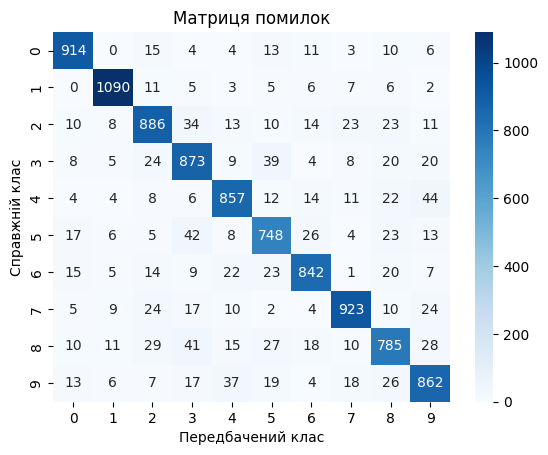

In [13]:
performance_evaluation(x_train_flat,x_test_flat)

### Performance evaluation - reduced data - only AE

Час навчання mlp - 163.64
Час затрачений для передбачення всіх x_test(10000) - 0.01 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 958.48 KB
classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       980
           1       0.95      0.95      0.95      1135
           2       0.89      0.84      0.86      1032
           3       0.85      0.85      0.85      1010
           4       0.87      0.86      0.86       982
           5       0.85      0.82      0.83       892
           6       0.90      0.91      0.91       958
           7       0.90      0.91      0.90      1028
           8       0.82      0.84      0.83       974
           9       0.84      0.84      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



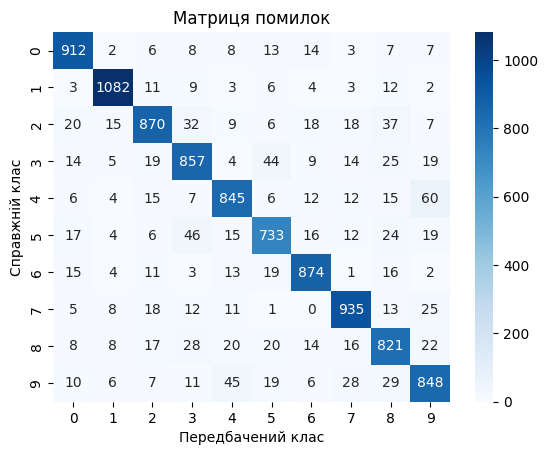

In [14]:
performance_evaluation(x_train_ae,x_test_ae)

### Performance evaluation - reduced data - only SVD

Час навчання mlp - 17.29539179801941
Час затрачений для передбачення всіх x_test(10000) - 0.01251983642578125 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



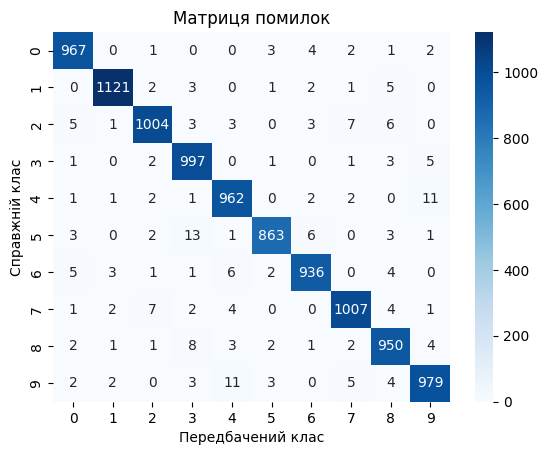

In [20]:
# note: use x train without AE
# performance_evaluation(x_train_svd,x_test_svd)

### Performance evaluation - reduced data

Час навчання mlp - 33.54
Час затрачений для передбачення всіх x_test(10000) - 0.0 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 1366.29 KB
classification report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       980
           1       0.96      0.96      0.96      1135
           2       0.85      0.83      0.84      1032
           3       0.79      0.81      0.80      1010
           4       0.78      0.81      0.80       982
           5       0.79      0.75      0.77       892
           6       0.89      0.89      0.89       958
           7       0.86      0.84      0.85      1028
           8       0.74      0.73      0.74       974
           9       0.78      0.79      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



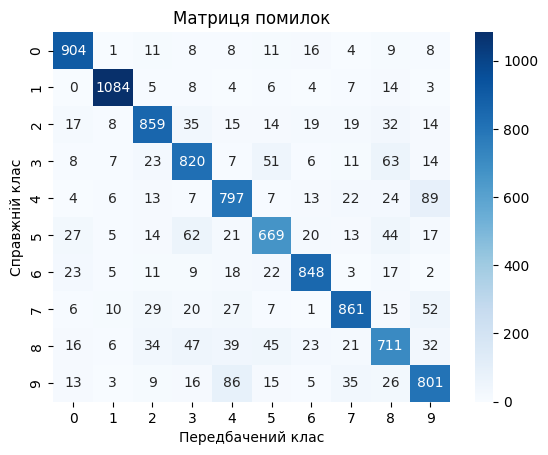

In [15]:
performance_evaluation(x_train_reduced,x_test_reduced)

### print all data size

In [16]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних       - { x1 } байт")
print(f"Розмір після автоенкодера       - { x2 } байт ({x2/x1})")
print(f"Розмір після автоенкодера + SVD - { x3 } байт ({x3/x2})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 188160128 байт (0.9999999149660515)
Розмір після автоенкодера + SVD - 34560128 байт (0.1836740247115478)


# visualisation

In [17]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [18]:
X_recovered = svd.inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [19]:
x_svd_lat = x_train_svd.reshape(len(x_train_svd), lat_dim_svd, -1)
x_svd_lat.shape

(60000, 12, 12)

In [20]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

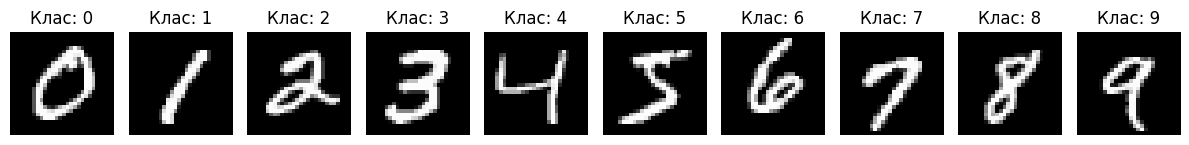

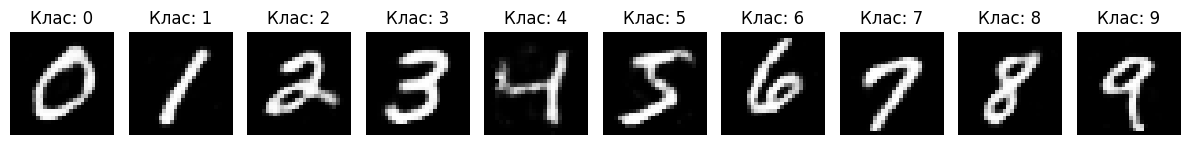

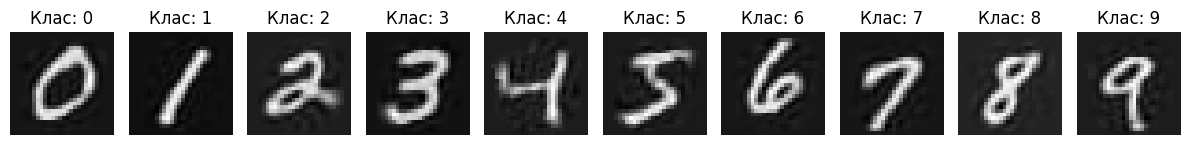

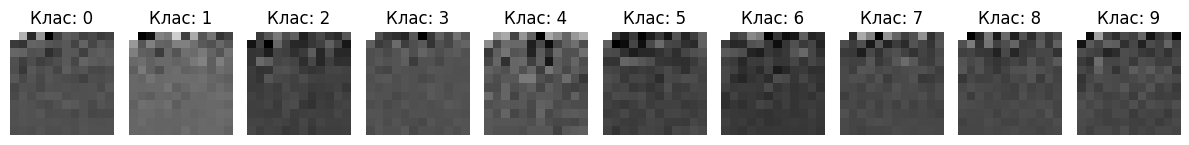

In [21]:
plot_classes(x_train,y_train)
plot_classes(x_ae,y_train)
plot_classes(x_svd,y_train) # after svd inverse
plot_classes(x_svd_lat,y_train) # clean svd